In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [15]:
train = pd.read_csv('C:/Users/kums5/train.csv')
test = pd.read_csv('C:/Users/kums5/test.csv')
ss = pd.read_csv('C:/Users/kums5/sample_submission.csv')

In [16]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [18]:
train.dropna(inplace=True)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [20]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [21]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


In [22]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


Text(0.5, 1.0, 'Target Rate')

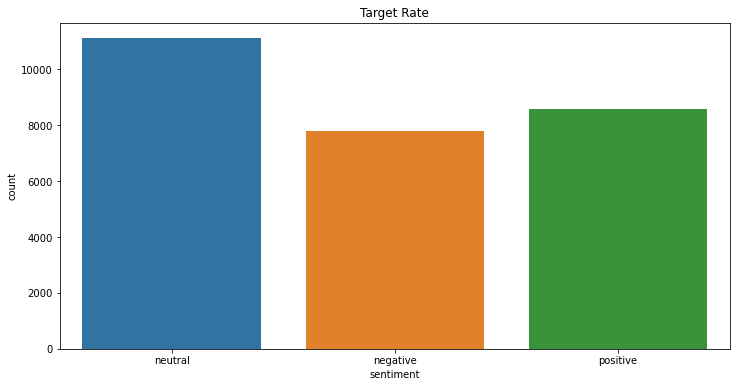

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)
plt.title('Target Rate')

In [24]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [25]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [26]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model

np.random.seed(42)
tf.random.set_seed(42)

In [44]:
# 데이터 불러오기
x_train = train['text']
y_train = train['sentiment']
x_test = test['text']
y_test = test['sentiment']


x_test = x_test.astype(str)

# 라벨 인코딩
encoder = LabelEncoder()
labels = encoder.fit_transform(y_train)
y_train_encoded = labels
labels_test = encoder.transform(y_test)
y_test_encoded = labels_test

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
# Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1  # 단어 집합(vocab)의 크기
x_encoded = tokenizer.texts_to_sequences(x_train)

maxlen_pad = 300

X_train = pad_sequences(x_encoded, maxlen=maxlen_pad, padding='post')
y_train = np.array(labels)
y_train = y_train.reshape(-1, 1)

X_test_encoded = tokenizer.texts_to_sequences(x_test)

X_test = pad_sequences(X_test_encoded, maxlen=300, padding='post')
y_test = np.array(y_test)

embed_dim = 256
num_heads = 4
ff_dim = 32
maxlen = 300

inputs = keras.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [45]:
# 모델 학습
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

In [46]:
# 모델 요약 정보 출력
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300)]             0         
                                                                 
 token_and_position_embeddin  (None, 300, 256)         6868224   
 g_5 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_4 (Transf  (None, 300, 256)         1069600   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 128)               3289

In [47]:
model_his = model.fit(X_train, y_train_encoded, batch_size=128, epochs=5, validation_data=(X_test, y_test_encoded))

Epoch 1/5
215/215 [==============================] - 297s 1s/step - loss: -4.0296 - accuracy: 0.4045 - precision: 0.7168 - val_loss: -12.6091 - val_accuracy: 0.4046 - val_precision: 0.7168
Epoch 2/5
215/215 [==============================] - 288s 1s/step - loss: -711.2864 - accuracy: 0.4270 - precision: 0.7444 - val_loss: -2134.5657 - val_accuracy: 0.4046 - val_precision: 0.7168
Epoch 3/5
215/215 [==============================] - 293s 1s/step - loss: -6363.0439 - accuracy: 0.4337 - precision: 0.7523 - val_loss: -10954.2295 - val_accuracy: 0.4061 - val_precision: 0.7180
Epoch 4/5
215/215 [==============================] - 298s 1s/step - loss: -21511.0039 - accuracy: 0.4571 - precision: 0.7806 - val_loss: -32234.4062 - val_accuracy: 0.4046 - val_precision: 0.7168
Epoch 5/5
215/215 [==============================] - 295s 1s/step - loss: -50698.9922 - accuracy: 0.4373 - precision: 0.7574 - val_loss: -65989.0547 - val_accuracy: 0.4822 - val_precision: 0.8145
